In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Preliminary: Chaos Game for Sierpinski Triangle

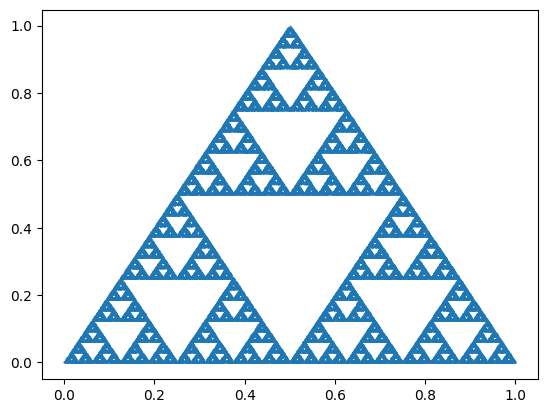

In [156]:
x = np.array([0.3, 0.]) # Arbitrary starting point
offsets = np.array([[0, 0], [0.25, 0.5], [0.5, 0]])

iters = 100000

X = np.zeros(iters)
Y = np.zeros(iters)

# Loop
for i, k in enumerate(np.random.randint(3, size=iters)):
    x = 0.5 * x + offsets[k] # These are the 3 functions (shrink and reposition somewhere)
    X[i] = x[0]
    Y[i] = x[1]

plt.rcParams["figure.dpi"] = 100
plt.scatter(X, Y, 0.1)
plt.show()

## Probability to 2-simplex mapping

How to read: (see the lines in the Z1R Mixed-State Simplex diagram from https://www.lesswrong.com/posts/gTZ2SxesbHckJ3CkF/transformers-represent-belief-state-geometry-in-their)

Bottom line is the first outcome probability. Left is probability 0, right is probability 1. Draw a positive slope line parallel to the triangle's left edge.

Right line is the second outcome probability. Bottom right is probability 0, top is probability 1. Draw a horizontal line.

Left line is the last outcome probability, top is probability 0, bottom left is probability 1. Draw a negative slope line parallel to the triangle's right edge.

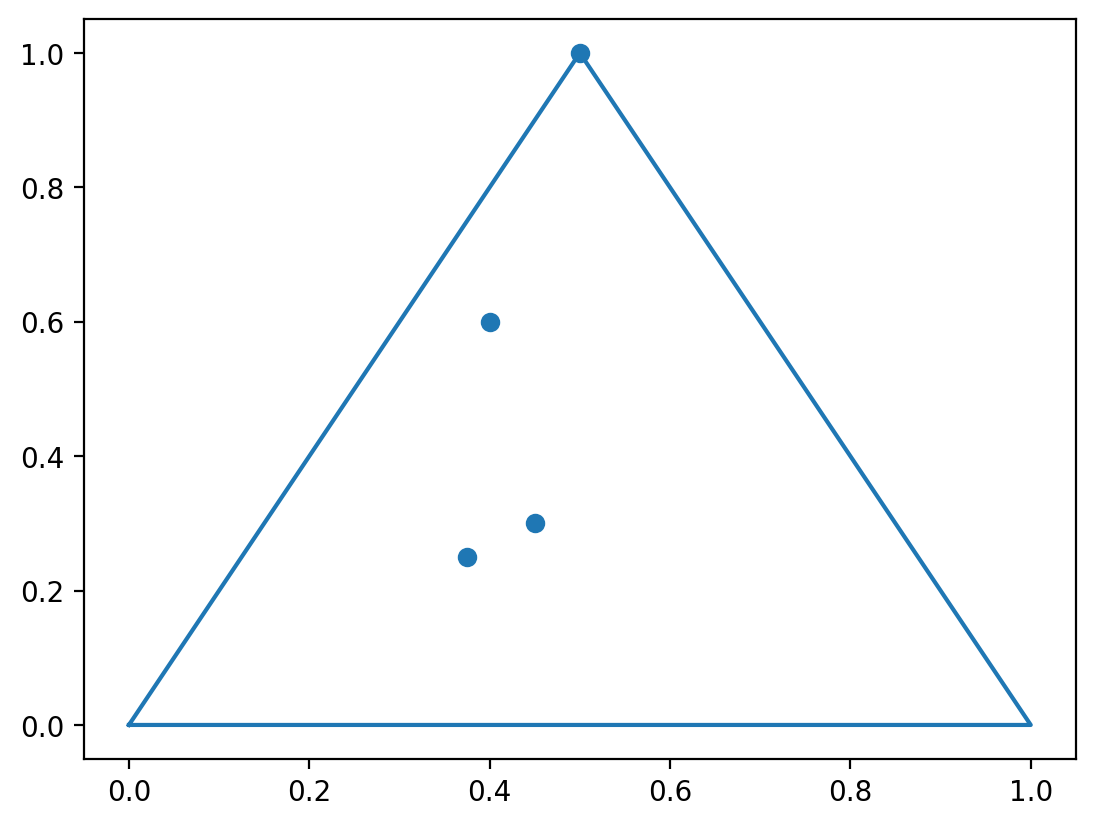

In [99]:
X = np.array([0, 1, 0.5, 0])
Y = np.array([0, 0, 1, 0])
plt.plot(X, Y)

pi = np.array([
    [0.1, 0.6, 0.3],
    [0, 1, 0],
    [0.3, 0.3, 0.4],
    [0.25, 0.25, 0.5]
])

# Probability to 2-simplex mapping
X = pi[:, 0] + pi[:, 1] / 2
Y = pi[:, 1]
plt.scatter(X, Y)
plt.show()

Z1R MSP: Chaos Game (non-fractal)

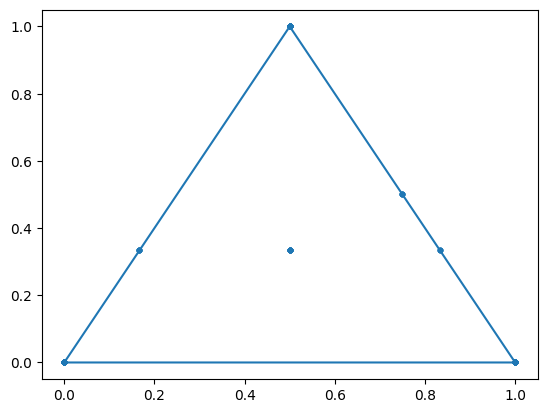

In [114]:
# Question: can we go from the HMM to the MSP fractal? Yes:
# 1. Generate an observation. 2. Update the current state prior.
# 3. Transition to the next state prior. 4. Embed prior in the simplex.

# First: generating an observation. For each output token: dot product the prior, and emission probability.
# To do this across all states at once, matrix multiply the emission (where column indices mark source states,
# and row indices mark tokens) times the prior vector.
#
# Next: given an observation, update prior by multiplying it by probability of emission.
# This is effectively deciding what probabilities correspond to the state.
# Just take the prior and multiply by the emission probability. Then divide by sum.
#
# Afterwards: we updated the prior for what state we are in, based on the observation. Now
# we need to update what prior we are in after taking a step.
#
# Last: embed the probabilities in the 2-simplex space with the above section's transformation.

def sample_chaos_game_points(reset_interval, iters, start_prior, emission_and_transition_pi):
    probs = np.zeros([iters, 3])
    for i in range(iters):
        if i % reset_interval == 0:
            prior = start_prior
            #print(f"Starting prior: {prior}\n")
        else:
            # Generate an observation
            emission_pi = np.sum(emission_and_transition_pi, axis=1)
            emission_pi /= np.sum(emission_pi, axis=0)
            obs_pi = emission_pi @ prior
            obs_pi /= np.sum(obs_pi)
            obs = np.random.choice(len(obs_pi), p=obs_pi)
            #print(f"Observation probabilities: {obs_pi}, sampled observation: {obs}")

            # Update current state prior
            prior = emission_pi[obs] * prior
            prior /= np.sum(prior)
            #print(f"Updated current-state prior: {prior}")

            # Transition to next state, knowing what token was emitted
            transition_pi = np.copy(emission_and_transition_pi[obs]) # Make sure to copy or else you will affect the original emission_and_transition_pi
            normalizer = np.sum(transition_pi, axis=0)
            normalizer = np.where(normalizer == 0, 1, normalizer)
            transition_pi /= normalizer
            prior = transition_pi @ prior
            #print(f"Next-state prior: {prior}\n")
        probs[i] = prior
    return probs

def plot_probs_on_simplex(probs, size=0.1):
    X = np.array([0, 1, 0.5, 0])
    Y = np.array([0, 0, 1, 0])
    plt.plot(X, Y)

    # Probability to 2-simplex mapping
    X = probs[:, 0] + probs[:, 1] / 2
    Y = probs[:, 1]
    plt.scatter(X, Y, size)
    plt.show()

# Stored value at emission_pi[token, target, source] is the probability of emitting token and transitioning from source to target
# Index 0 (emitted tokens): 0, 1
# Index 1 (target state): s1, s0, sR
# Index 2 (source state): s1, s0, sR
emission_and_transition_pi = np.array([
    [[0, 1.0, 0],
    [0, 0, 0.5],
    [0, 0, 0]],

    [[0, 0, 0],
    [0, 0, 0.5],
    [1.0, 0, 0]]
])

reset_interval = 10
iters = 10 * reset_interval # Reset 10 times because the chain has transient states: for Z1R we *want* to see all the transients
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs, 10)

# I calculated by hand prior to producing the plot, and observed that the Z1R MSP simplex
# from the LW post seems to be wrong. In particular, eta_0 should be on the same line
# as eta_1 and eta_S since it has S_0 probability 1/3, and eta_00 and eta_11 should be flipped
# (though you can't see it on this plot which removes the labels).
#
# As such I believe the below plot is indeed correct (matches my hand-calculations).

### Mess3 MSP: Chaos Game Fractal (parameters and matching MSP checks: https://arxiv.org/pdf/2102.10487)

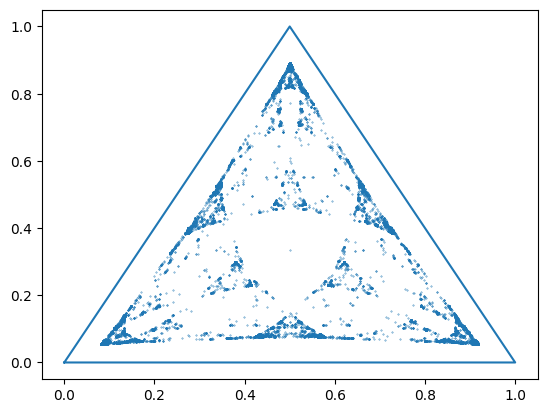

In [116]:
x = 0.05
alpha = 0.85

def mess3_parameters(x, alpha):
    beta = (1 - alpha) / 2
    y = 1 - 2 * x

    # Reminder: index 0 is symbol, index 1 (row) is target, index 2 (column) is source
    emission_and_transition_pi = np.array([
        [[alpha * y, beta * x, beta * x],
        [alpha * x, beta * y, beta * x],
        [alpha * x, beta * x, beta * y]],

        [[beta * y, alpha * x, beta * x],
        [beta * x, alpha * y, beta * x],
        [beta * x, alpha * x, beta * y]],

        [[beta * y, beta * x, alpha * x],
        [beta * x, beta * y, alpha * x],
        [beta * x, beta * x, alpha * y]]
    ])
    return emission_and_transition_pi

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

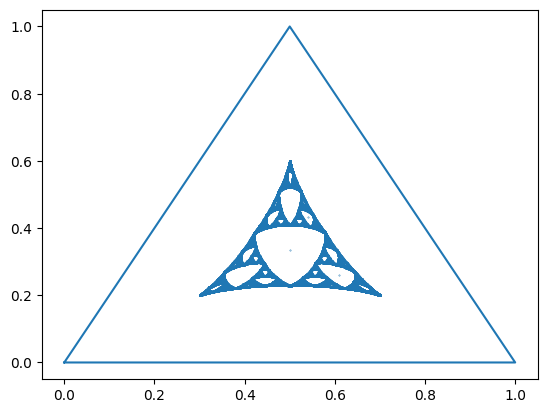

In [115]:
x = 0.15
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

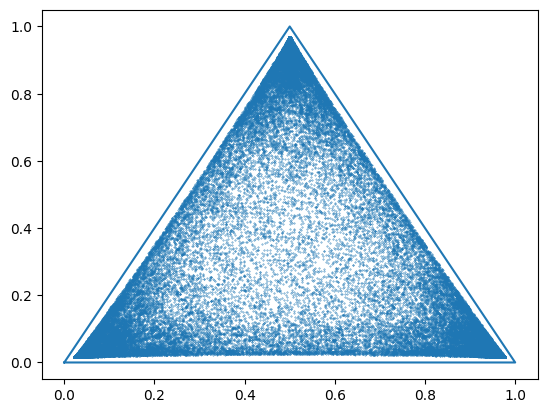

In [152]:
x = 0.01
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

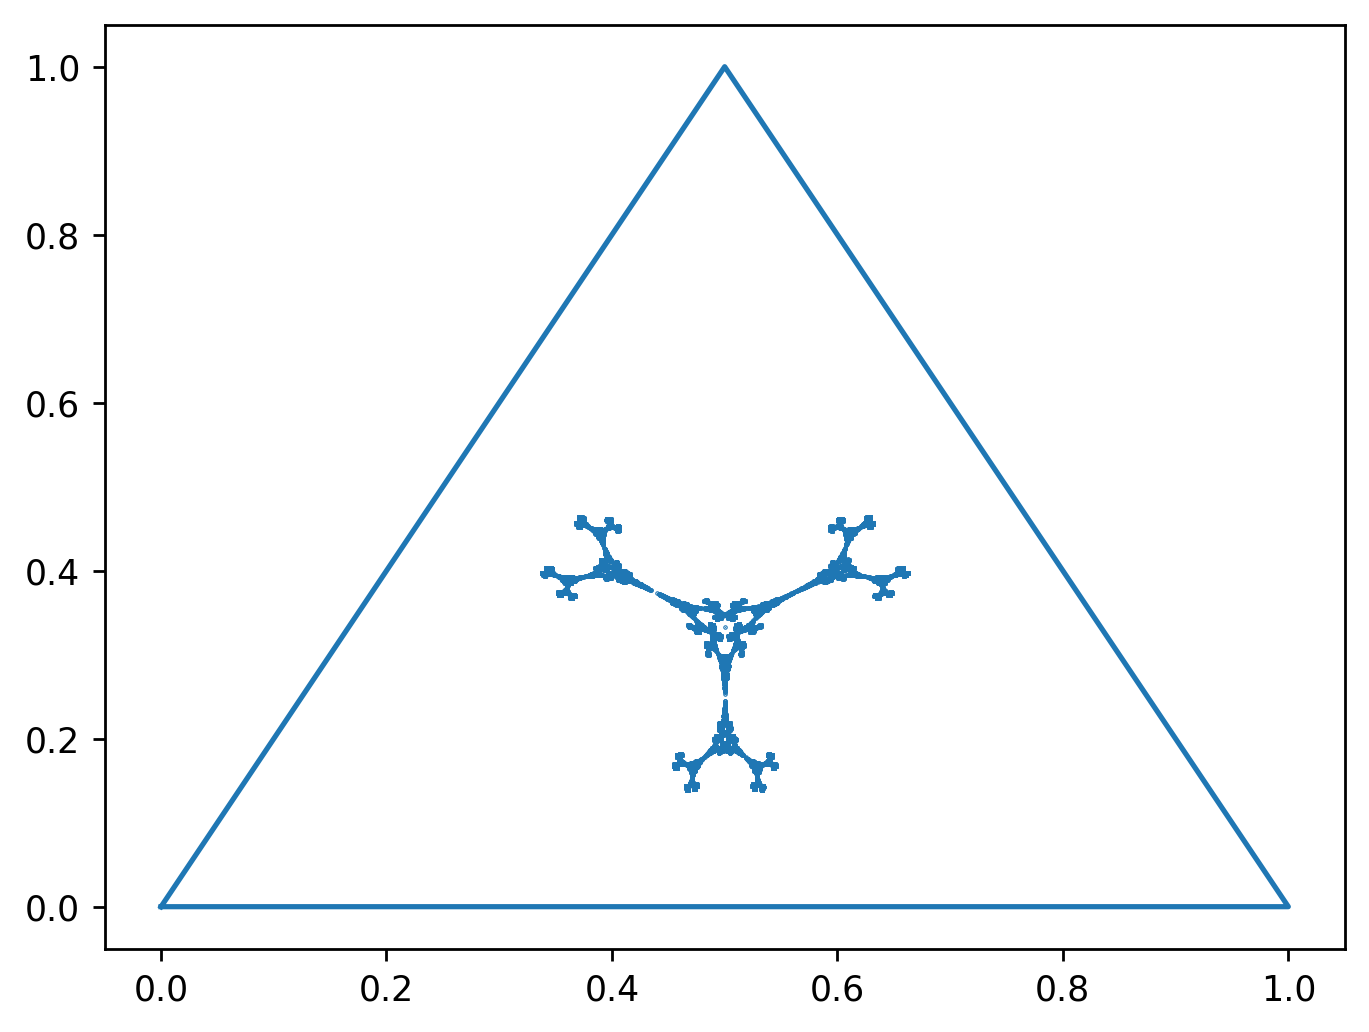

In [140]:
x = 0.5
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

plt.rcParams["figure.dpi"] = 250
probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

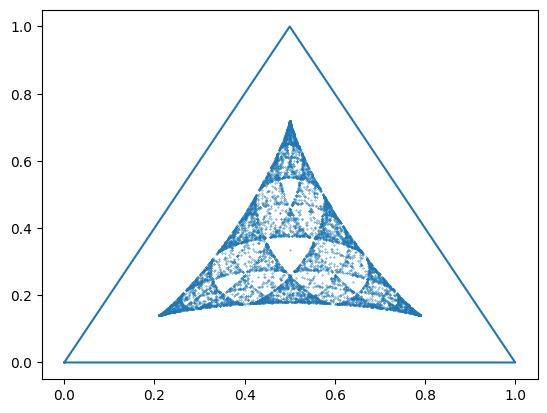

In [129]:
x = 0.1
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 10000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

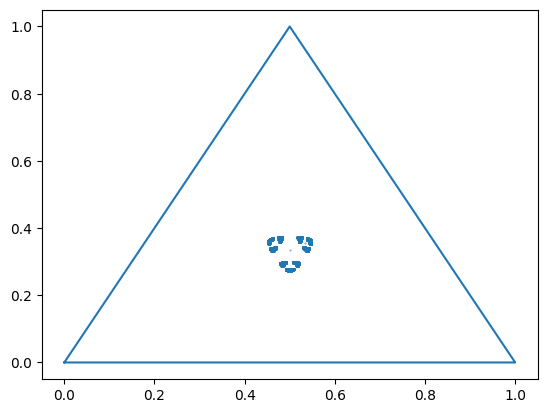

In [135]:
x = 0.21
alpha = 0.21

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 10000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

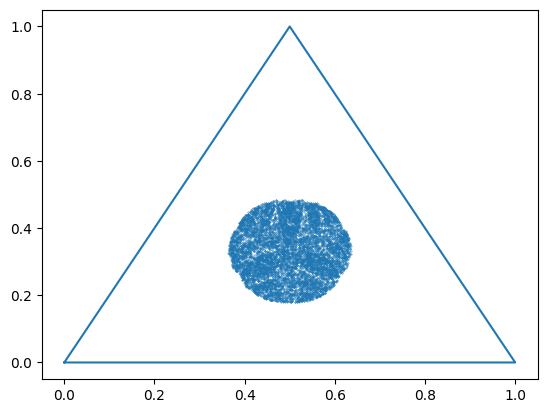

In [136]:
x = 0.11
alpha = 0.21

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 10000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

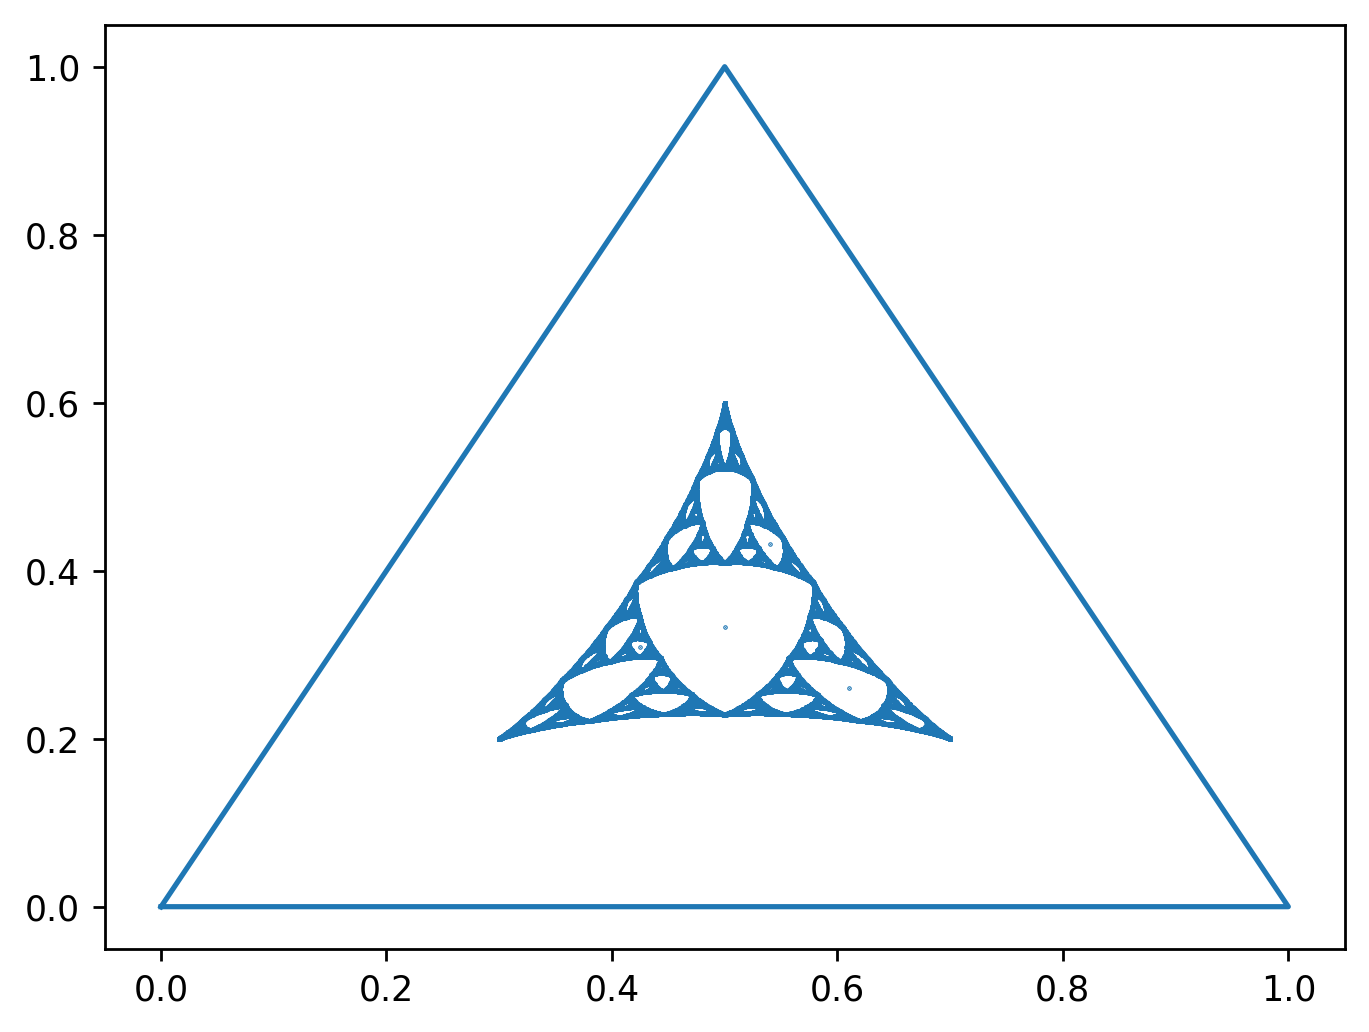

In [141]:
x = 0.15
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

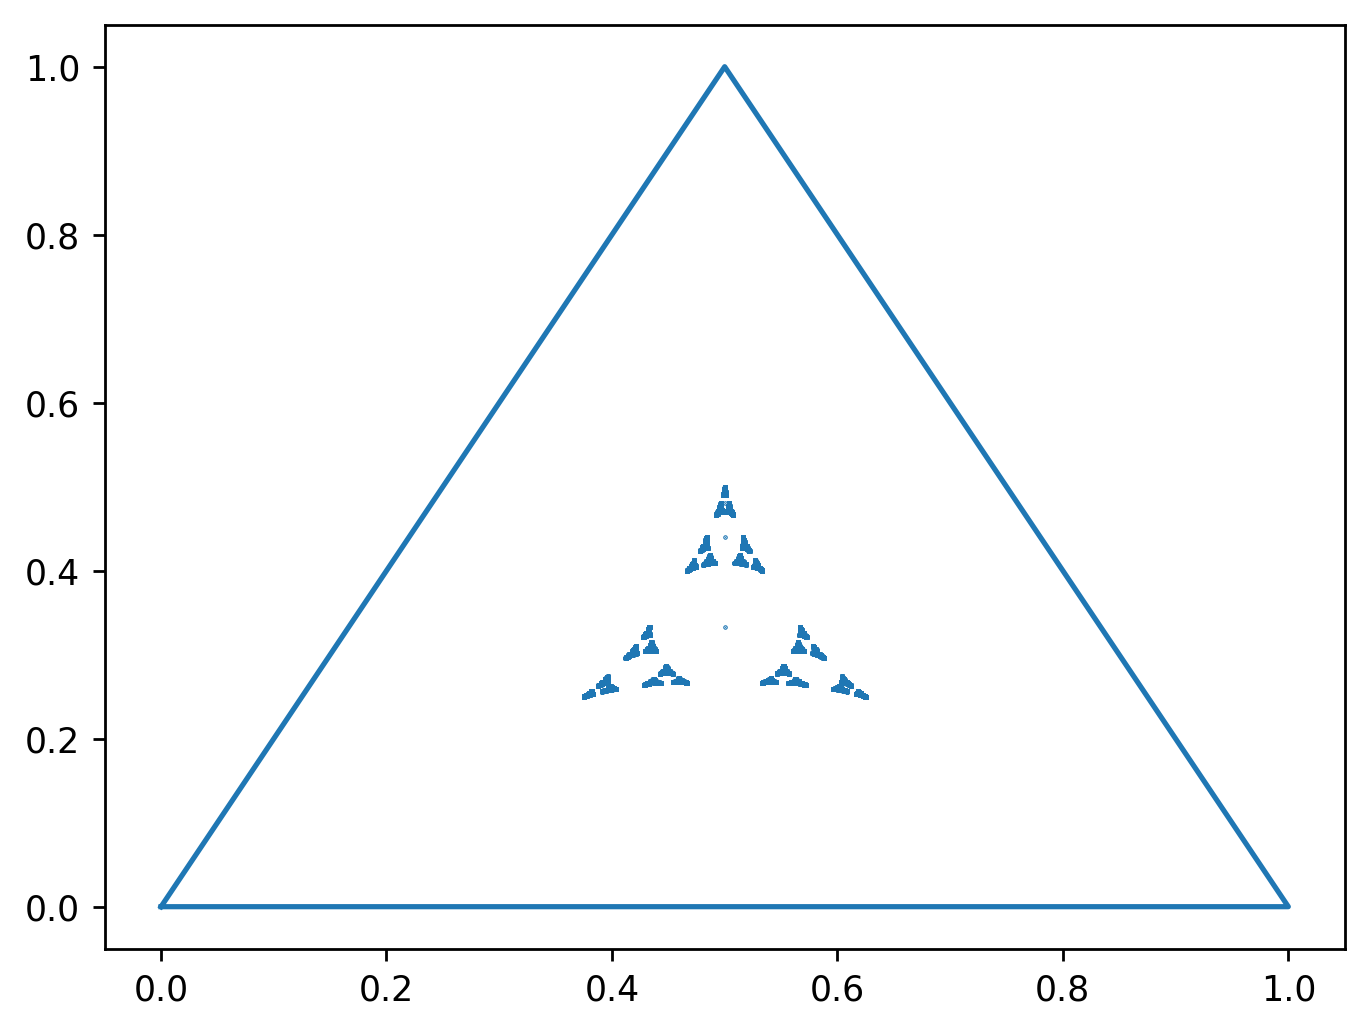

In [142]:
x = 0.2
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

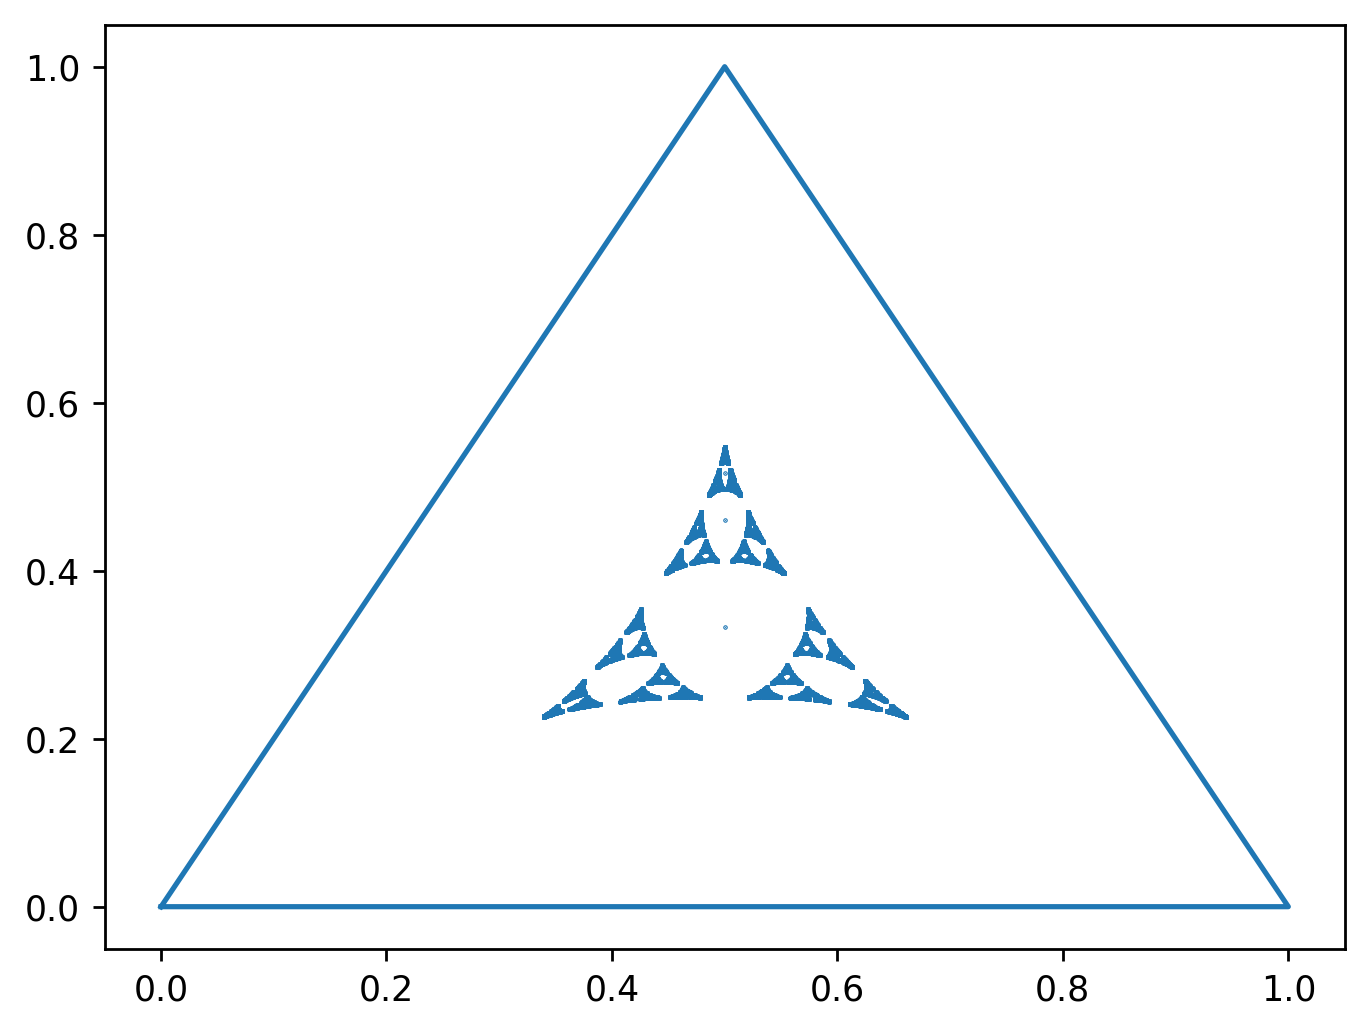

In [143]:
x = 0.175
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

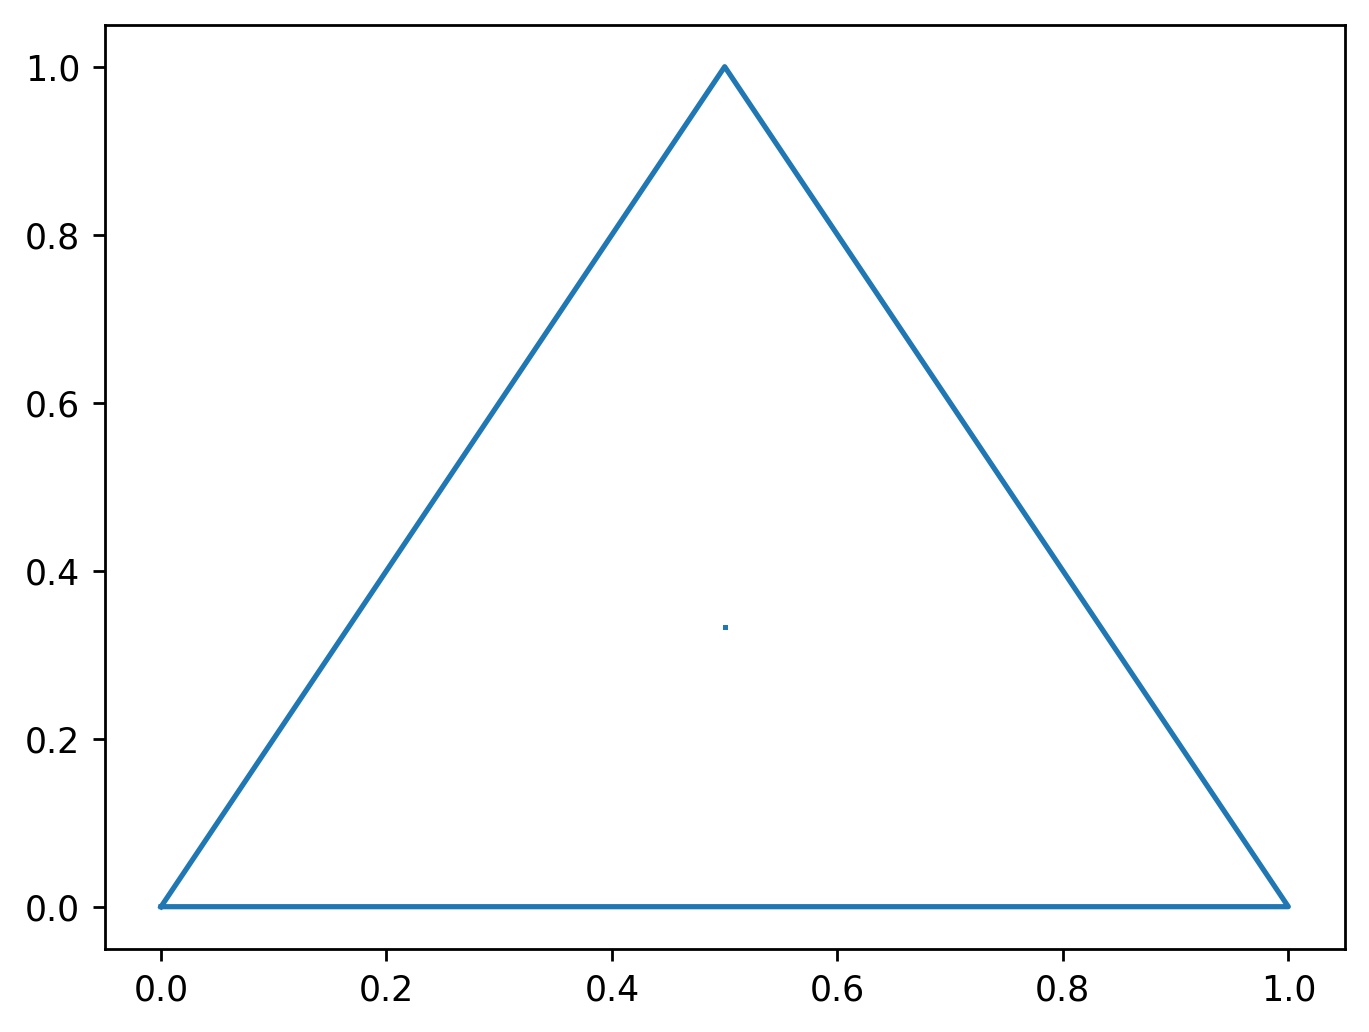

In [146]:
x = 1/3
alpha = 0.6

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 100000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

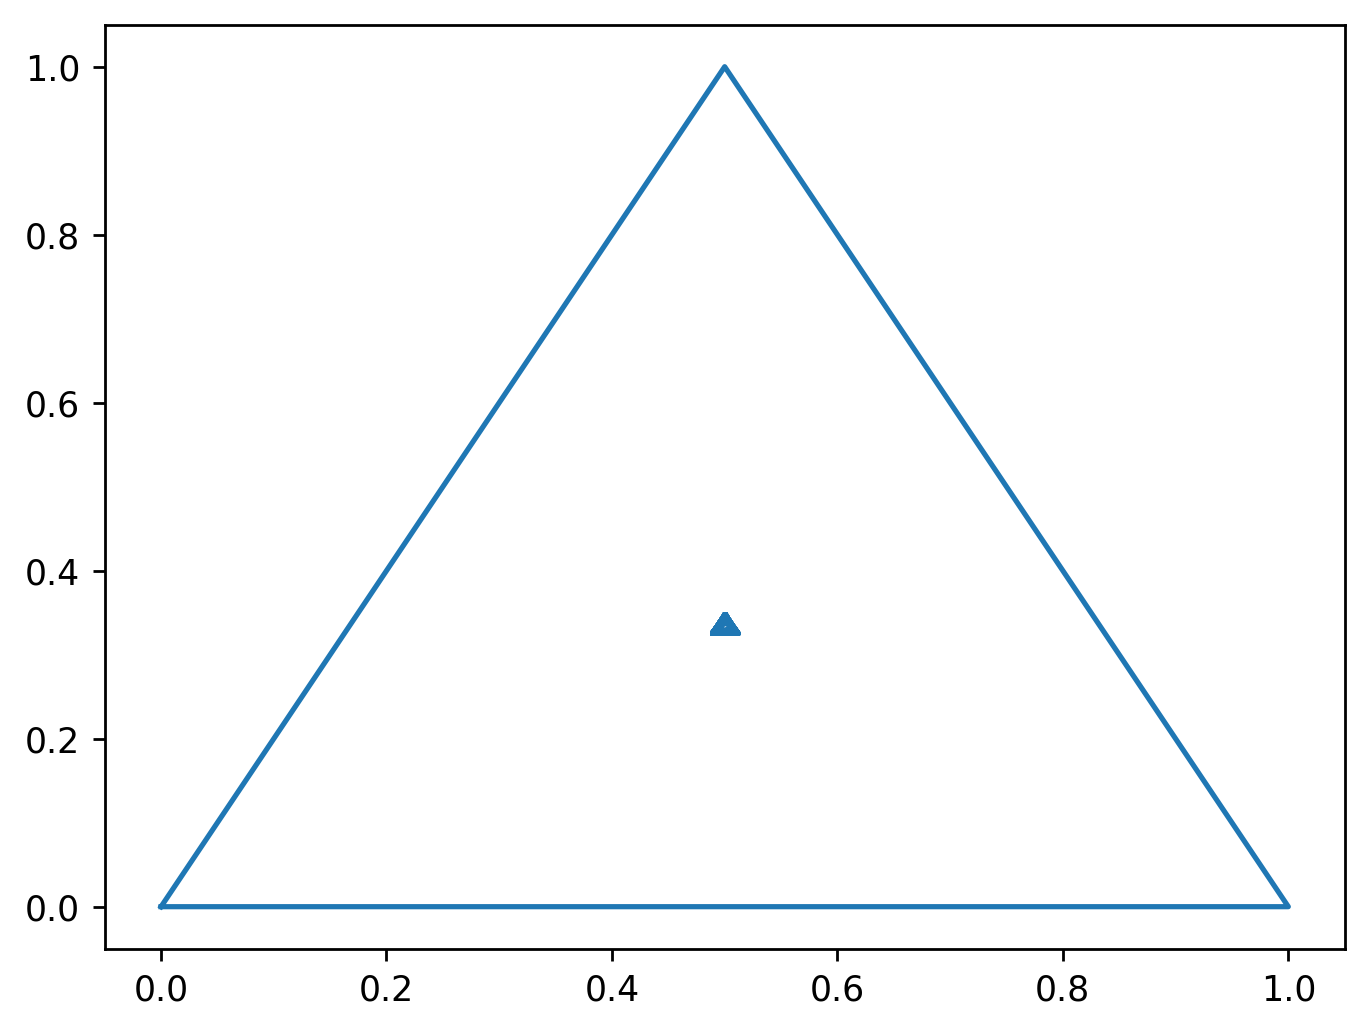

In [179]:
x = 0.175
alpha = 0.35

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 30000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

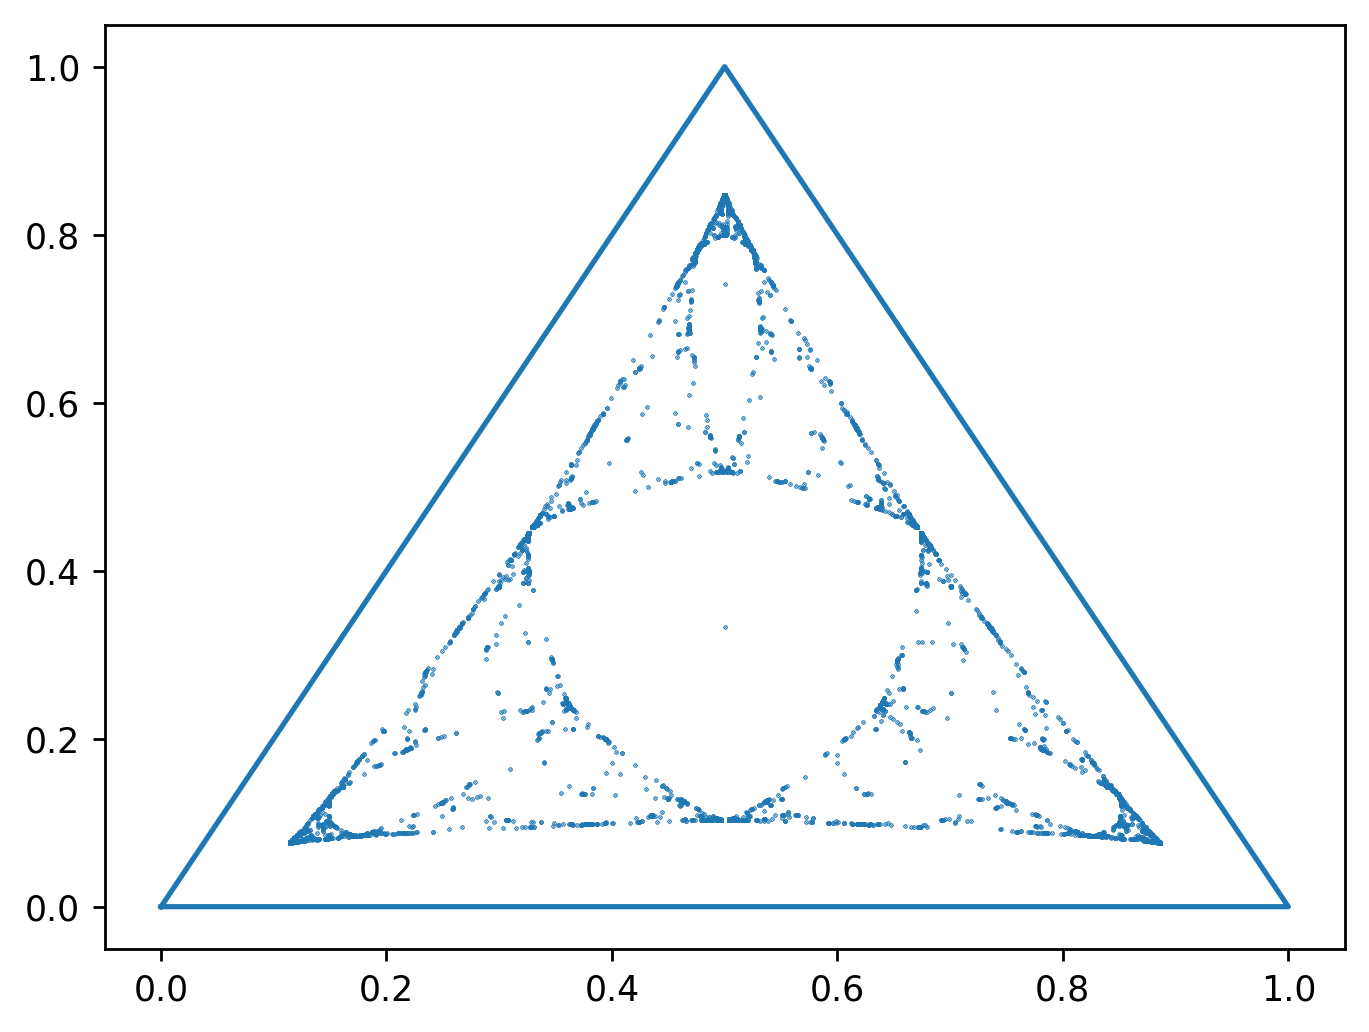

In [197]:
x = 0.07
alpha = 0.85

emission_and_transition_pi = mess3_parameters(x, alpha)
reset_interval = 30000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

Adjacency threshold (no gap, no overlap), expressed in (alpha, x):

(0.1, 0.105)

(0.2, 0.145)

(0.4, 0.18)

(0.6, 0.15)

(0.8, 0.09)

(0.85, 0.07)

For a given alpha: there seem to be thresholds for adjacency and point collapse for x (collapse at x = 1/3).
- Less than adjacency: overlapping.
- More than adjacency but less than point collapse: separated.
- Past point collapse: "inverted" (not really sure how this works).
- Just to have something to refer to them: call these regimes "overlap", "separate", and "inverted" (the thresholds "adjacent" and "collapse").

For alpha: there seems to be two regimes, on either side of alpha = 1/3. Call these "small" and "large" alpha regimes. The threshold (alpha = 1/3) is always a point (token emission gives no information about the state, since all states choose a token uniformly randomly).

In either alpha regime, an alpha closer to the threshold 0.333 makes it easier for the fractal to overlap (adjacency threshold for x is larger).

-----

So, roughly speaking, we know that more overlap looks like alpha closer to 1/3, and smaller x.

Large alpha, non-inverted, looks triangular. Small alpha looks circular or kind of flat.

What do these things tell us? How do the geometric observations relate to fractal properties? We can talk about shape (orientation?), scale, and position of the 3 transformation functions (i.e. the fractal pieces), just by observing the fractal. With relation to the underlying HMM, then (we can limit analysis to the symmetric and target-independent token generating HMM, mess3):
- 3-way symmetry seems to indicate that transition probabilities (or emission probabilities, not really clear) only depend on whether you're going to a different state or staying. Alpha and beta MSPs which are asymmetric in this sense exhibit asymmetry in the MSP fractal.
- Degree of overlap/separation indicates...?
- Size of the fractal (and scale of the pieces relative to the parent) indicates...?

Obviously with mess3 there are some particular patterns. I can pretty easily tell whether alpha is greater or less than 1/3, and which regime x is in (overlap/separate/inverted). With a bit more data I can potentially get a pretty good estimate of what the parameters are exactly.

But more fundamentally, what are the composition functions (dunno what the terminology is) for the fractals? And how do they differ based on the underlying HMM? In other words, **why** is it the case that the regimes are what they are? Put a different way, alpha and x represent some more general properties of 3-state HMMs. How do those general properties relate to the MSP fractal?

What properties of the 3-state HMM are there, even? The HMM can be fully parameterized by 9 * num_tokens. For a 3 token vocabulary, it's 27. When we talk about the topology of the HMM being different (for a given number of states), maybe we mean that the transition matrix has some 0s in certain places so the connection is not even there. Unifilar HMMs must have 0s in certain places, for example.

Alpha MSP (does not seem to be working)

[1.000425  1.0003966 0.9999958]


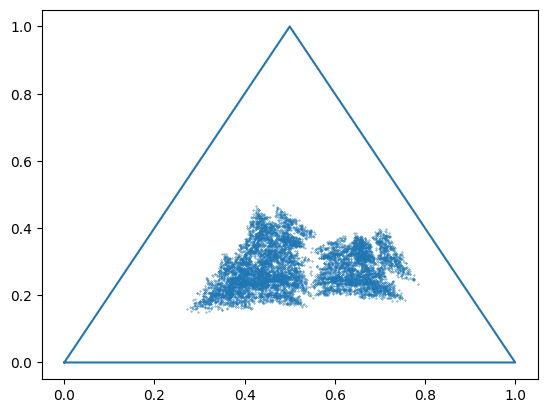

In [132]:
emission_and_transition_pi = np.array([
    [[0.02734, 0.392, 0.01924],
    [0.475, 0.02176, 0.0002766],
    [0.224, 0.002711, 0.236]],

    [[0.001845, 0.133, 0.259],
    [0.03913, 0.315, 0.02789],
    [0.467, 0.01015, 0.004699]],

    [[0.09782, 0.03374, 0.03644],
    [0.05422, 0.06503, 0.00209],
    [0.05328, 0.001278, 0.0008778]]
])

print(np.sum(emission_and_transition_pi, axis=(0, 2)))

reset_interval = 10000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)

Beta MSP (also not really working...)

[1.000784  1.000195  0.9992737]


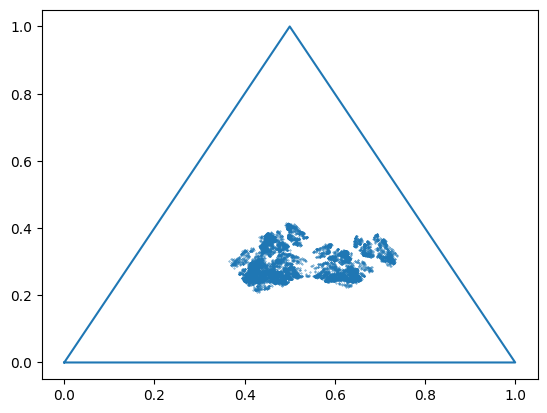

In [139]:
emission_and_transition_pi = np.array([
    [[0.05001, 0.388, 0.04251],
    [0.464, 0.04484, 0.02495],
    [0.232, 0.0272, 0.243]],

    [[0.001708, 0.123, 0.240],
    [0.03623, 0.292, 0.02583],
    [0.432, 0.009397, 0.004351]],

    [[0.090576, 0.03124, 0.03374],
    [0.05020, 0.06021, 0.001935],
    [0.04933, 0.001183, 0.0008127]]
])

print(np.sum(emission_and_transition_pi, axis=(0, 2)))

reset_interval = 10000
iters = 1 * reset_interval # Reset as few times as possible because we don't want to see transient states, just the attractor
prior = np.array([1/3, 1/3, 1/3])

probs = sample_chaos_game_points(reset_interval, iters, prior, emission_and_transition_pi)
plot_probs_on_simplex(probs)